In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random
from tempfile import TemporaryDirectory


In [6]:
TACO_DIR = Path("/Users/hariomnarang/Desktop/personal/TACO/data")
ANN_FILE = TACO_DIR / "annotations.json"
EXP_BASE = Path("../../datasets/T007-uncentered/")
OUT_DIR = EXP_BASE / "data"
OUT_DIR.mkdir(parents=True, exist_ok=True)
# with TemporaryDirectory() as tmp:
#     tmp = Path(tmp)
#     extract_images_and_masks(ann_file=ANN_FILE, taco_dir=TACO_DIR, output_path=tmp, num_samples=10)
#     collapse_to_binary_dataset(tmp, OUT_DIR)

FileNotFoundError: [Errno 2] No such file or directory: '../../datasets/T007-uncentered/data/images/342.jpeg'

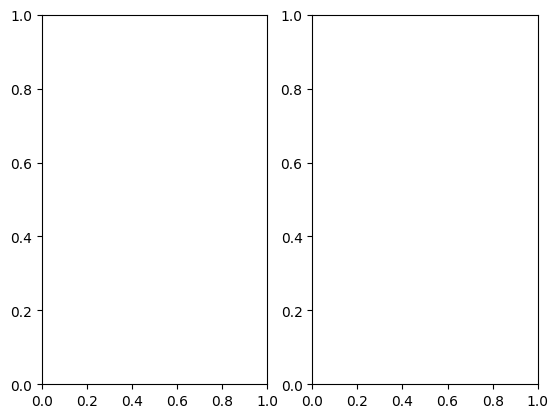

In [5]:
image = OUT_DIR / "images" / "342.jpeg"
mask = OUT_DIR / "masks" / "342.png"

_, ax = plt.subplots(1, 2)
ax[0].imshow(plt.imread(image))
ax[1].imshow(plt.imread(mask))

# Why is the mask inverted?



In [41]:
from pycocotools.coco import COCO

coco = COCO(ANN_FILE)

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


In [96]:
img_info = coco.loadImgs(342)[0]
img_info

{'id': 342,
 'width': 2988,
 'height': 5312,
 'file_name': 'batch_12/000041.jpg',
 'license': 'ODBL (c) OpenLitterMap & Contributors',
 'flickr_url': 'https://olm-s3.s3.eu-west-1.amazonaws.com/2018/08/22/aMpHeYJoQUWb952N5dXy4wqUe1IZxoxu6q7i10TN.jpeg',
 'flickr_640_url': None,
 'coco_url': None,
 'date_captured': None}

In [48]:
category_ids = sorted(
    {ann["category_id"] for ann in coco.loadAnns(coco.getAnnIds())}
)
catid2maskid = {
    cat_id: i + 1 for i, cat_id in enumerate(category_ids)
}  # 0 = background
codes = ["background"] + [
    coco.loadCats(cat_id)[0]["name"] for cat_id in category_ids
]

In [52]:
import os
from PIL import Image

img_id = img_info["id"]
img_filename = img_info["file_name"]

# Load image
img_path = os.path.join(TACO_DIR, img_filename)
img = Image.open(img_path).convert("RGB")
img_array = np.array(img)
img_height, img_width = img_array.shape[:2]

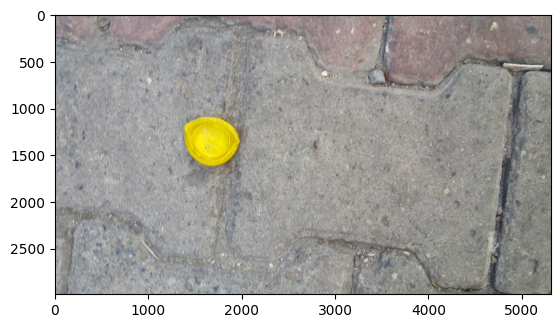

In [54]:
plt.imshow(img_array)

In [55]:
ann_ids = coco.getAnnIds(imgIds=img_id)
anns = coco.loadAnns(ann_ids)

# Create mask
mask = np.zeros((img_height, img_width), dtype=np.uint8)

In [58]:
anns

[{'id': 1124,
  'image_id': 342,
  'category_id': 7,
  'segmentation': [[1531.0,
    1422.0,
    1457.0,
    1475.0,
    1409.0,
    1538.0,
    1380.0,
    1604.0,
    1361.0,
    1665.0,
    1383.0,
    1795.0,
    1434.0,
    1873.0,
    1541.0,
    1948.0,
    1639.0,
    1979.0,
    1727.0,
    1946.0,
    1818.0,
    1870.0,
    1873.0,
    1780.0,
    1886.0,
    1650.0,
    1886.0,
    1545.0,
    1843.0,
    1443.0,
    1804.0,
    1385.0,
    1740.0,
    1384.0,
    1672.0,
    1377.0,
    1616.0,
    1392.0]],
  'area': 242326.0,
  'bbox': [1361.0, 1377.0, 525.0, 602.0],
  'iscrowd': 0},
 {'id': 1125,
  'image_id': 342,
  'category_id': 58,
  'segmentation': [[2463.0,
    4806.0,
    2424.0,
    4791.0,
    2393.0,
    4885.0,
    2378.0,
    4983.0,
    2383.0,
    5129.0,
    2385.0,
    5202.0,
    2441.0,
    5214.0,
    2454.0,
    4985.0]],
  'area': 26482.5,
  'bbox': [2378.0, 4791.0, 85.0, 423.0],
  'iscrowd': 0}]

In [61]:
mask = np.zeros(img_array.shape[:2], dtype=np.uint8)

In [62]:
seg0 = np.array(anns[0]['segmentation']).reshape((-1, 2)).astype(np.int32)

In [78]:
image

PosixPath('../../datasets/T007-uncentered/data/images/342.jpeg')

AttributeError: 'COCO' object has no attribute 'getImgs'

In [ ]:
! fd "324.jpeg" '/Users/hariomnarang/Desktop/personal/TACO/data/' 

In [ ]:
TACO_DIR / "data"

PosixPath('/Users/hariomnarang/Desktop/personal/TACO/data/data')

270


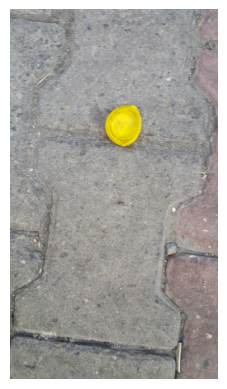

In [ ]:

from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys

annIds = coco.getAnnIds(imgIds=img_id, catIds=[], iscrowd=None)
anns_sel = coco.loadAnns(annIds)

I = Image.open(TACO_DIR / "batch_12/000041.jpg")

for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break
# Load and process image metadata
if I._getexif():
    exif = dict(I._getexif().items())
    # Rotate portrait and upside down images if necessary
    if orientation in exif:
        if exif[orientation] == 3:
            print("180")
            I = I.rotate(180,expand=True)
        if exif[orientation] == 6:
            print("270")
            I = I.rotate(270,expand=True)
        if exif[orientation] == 8:
            print("90")
            I = I.rotate(90,expand=True)


def anns_to_mask(anns_sel, height, width, value=1):
    """
    Convert COCO-style annotations to a binary mask
    """
    mask = np.zeros((height, width), dtype=np.uint8)

    for ann in anns_sel:
        for seg in ann['segmentation']:
            poly = np.array(seg, dtype=np.int32).reshape(-1, 2)
            cv2.fillPoly(mask, [poly], value)

    return mask

fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(I)

# # Show annotations
# for ann in anns_sel:
#     color = '#0f0f0f'
#     for seg in ann['segmentation']:
#         poly = Polygon(np.array(seg).reshape((int(len(seg)/2), 2)))
#         p = PatchCollection([poly], facecolor=color, edgecolors=color,linewidths=0, alpha=0.4)
#         ax.add_collection(p)
#         p = PatchCollection([poly], facecolor='none', edgecolors=color, linewidths=2)
#         ax.add_collection(p)
#     [x, y, w, h] = ann['bbox']
#     rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
#                         facecolor='none', alpha=0.7, linestyle = '--')
#     ax.add_patch(rect)

In [101]:
type(I)

PIL.Image.Image

In [84]:
I._getexif()

In [72]:
np.array(anns[0]['segmentation']).reshape((-1, 2)).shape

(19, 2)

In [81]:
orientation

274

In [71]:
np.array(anns[0]['segmentation']).shape

(1, 38)

In [64]:
mask = cv2.fillPoly(mask, [seg0], color=255)

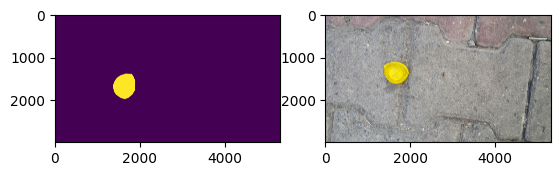

In [66]:
_, ax= plt.subplots(1, 2)
ax[0].imshow(mask)
ax[1].imshow(img_array)

In [36]:
from PIL import Image
from mtrain.smallnet.tfms import PaddedResize

def extract_single_crop(coco, img_path, mask_path, crop_size, max_padding):
    # Pick a random annotation to center the crop around

    img_id = int(img_path.stem)
    img = Image.open(img_path).convert("RGB")
    img_array = np.array(img)
    img_height, img_width = img_array.shape[:2]

    mask = Image.open(mask_path)
    mask_array = np.array(mask)

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    ann = random.choice(anns)
    x, y, w, h = ann["bbox"]

    # Random padding on each side
    pad_left = random.randint(0, max_padding)
    pad_right = random.randint(0, max_padding)
    pad_top = random.randint(0, max_padding)
    pad_bottom = random.randint(0, max_padding)
    print("paddings", pad_left, pad_top, pad_right, pad_bottom)
    print("x y w h", x, y, w, h)

    # Calculate crop boundaries
    crop_x1 = max(0, int(x - pad_left))
    crop_y1 = max(0, int(y - pad_top))
    crop_x2 = min(img_width, int(x + w + pad_right))
    crop_y2 = min(img_height, int(y + h + pad_bottom))

    print("crop x1,y1", crop_x1, crop_y1, "x2,y2", crop_x2, crop_y2)

    # Crop image and mask
    crop_img = img_array[crop_y1:crop_y2, crop_x1:crop_x2]
    crop_mask = mask_array[crop_y1:crop_y2, crop_x1:crop_x2]
    return crop_img, crop_mask
    # resizer = PaddedResize(crop_size)
    # crop_img_resized = resizer(crop_img)
    # crop_mask_resized = resizer(crop_mask)

    # crop_bbox = [crop_x1, crop_y1, crop_x2 - crop_x1, crop_y2 - crop_y1]
    # return (crop_img_resized, crop_mask_resized, crop_bbox)


In [37]:
coco = COCO(ANN_FILE)
resized_img, resized_mask = extract_single_crop(coco, image, mask, 50, max_padding=500)

# resized_img, resized_mask, box = extract_single_crop(coco, image, mask, 50, max_padding=500)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
paddings 491 221 45 173
x y w h 1361.0 1377.0 525.0 602.0
crop x1,y1 870 1156 x2,y2 1931 2152


In [38]:
resized_img.shape

(996, 1061, 3)

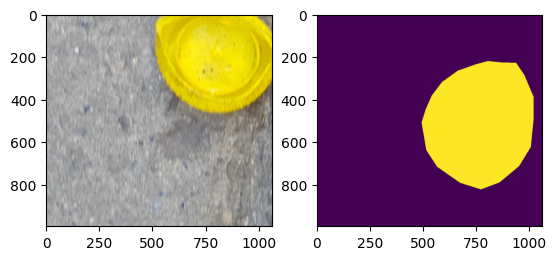

In [39]:
_,ax = plt.subplots(1,2)
ax[0].imshow(resized_img)
ax[1].imshow(resized_mask)